# High Risk Project Introduction
Drug-drug interactions (DDIs) pose significant risks in clinical practice, potentially leading to adverse effects, reduced therapeutic efficacy, or life-threatening complications. Traditional methods for identifying DDIs rely on curated databases or manual literature reviews, which are often incomplete or lag behind newly approved drugs. This project leverages a neural network model to predict potential interactions between drug pairs by analyzing their structural and pharmacological properties. The model employs embedding layers to represent drugs in a high-dimensional space, followed by fully connected layers to assess interaction risk, offering a scalable and data-driven approach to complement existing pharmacovigilance systems.

# Project Objective
The primary objective of this project is to develop an AI-powered tool that predicts the severity of drug-drug interactions with interpretable risk scores. By training on known interaction datasets, the model aims to:

Identify high-risk combinations for clinicians and pharmacists, reducing preventable adverse events.

Augment decision-making in polypharmacy scenarios, particularly for patients with complex medication regimens.

Provide real-time analysis for newly approved drugs lacking extensive interaction data in existing databases.

The solution combines deep learning with an intuitive Streamlit interface, bridging the gap between predictive analytics and clinical workflow integration.#

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import networkx as nx

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter




In [2]:
# Load the dataset
df = pd.read_csv('data/db_drug_interactions.csv')



In [3]:
# Basic info
print(f"Dataset shape: {df.shape}")
print(f"Number of unique drugs: {len(set(df['Drug 1']).union(set(df['Drug 2'])))}")

Dataset shape: (191541, 3)
Number of unique drugs: 1701


In [4]:
# Top 10 most frequent drugs
all_drugs = list(df['Drug 1']) + list(df['Drug 2'])
top_10_drugs = [drug for drug, count in Counter(all_drugs).most_common(10)]

### EDA (Exploratory Data Analysis)

In [5]:
# Filter dataset to include only top 10 drugs
filtered_df = df[df['Drug 1'].isin(top_10_drugs) & df['Drug 2'].isin(top_10_drugs)]

### # Visualization 1: Top 10 most common drugs


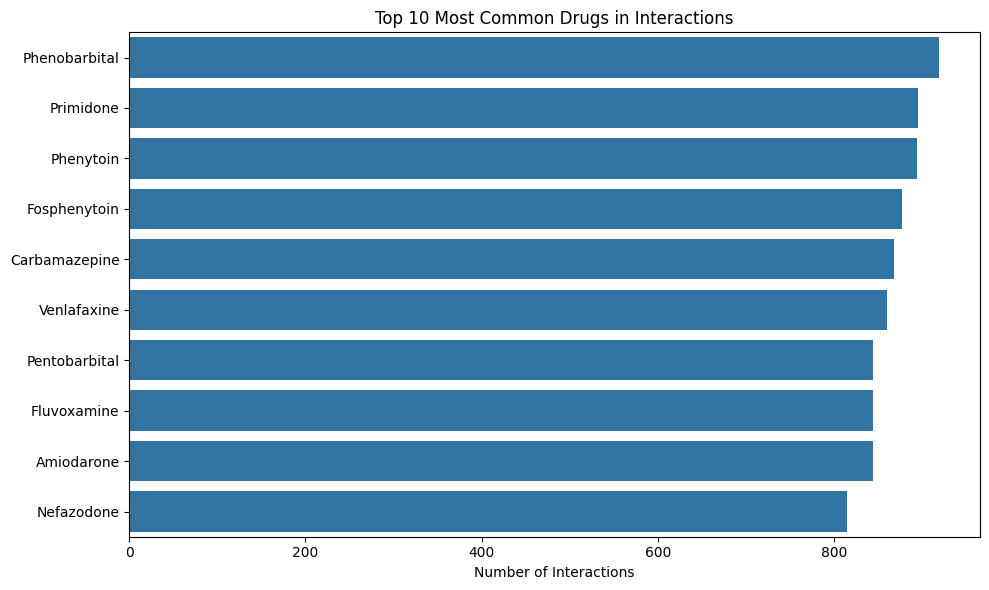

In [6]:
plt.figure(figsize=(10, 6))
sns.barplot(x=[count for drug, count in Counter(all_drugs).most_common(10)], 
            y=[drug for drug, count in Counter(all_drugs).most_common(10)])
plt.title('Top 10 Most Common Drugs in Interactions')
plt.xlabel('Number of Interactions')
plt.tight_layout()
plt.show()

### # Visualization 2: Interaction network of top 10 drugs


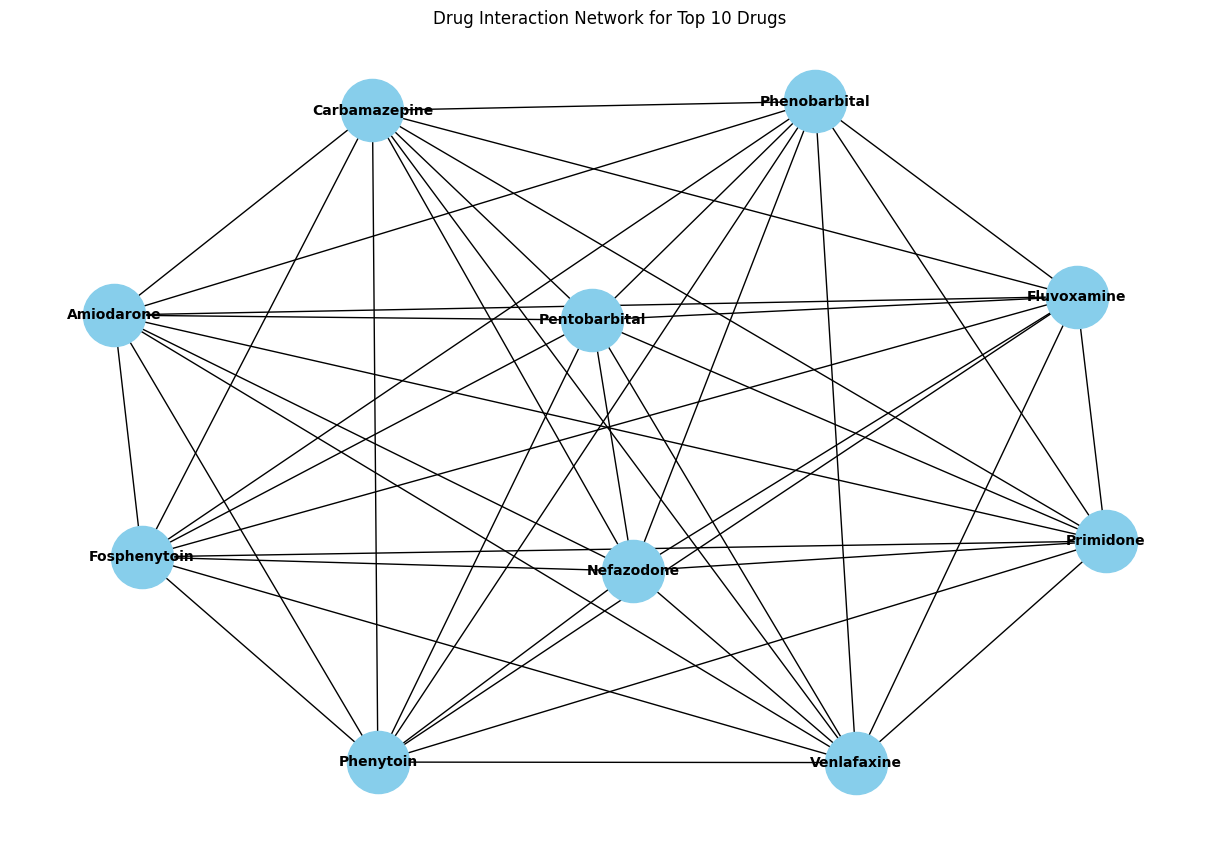

In [7]:
G = nx.from_pandas_edgelist(filtered_df, 'Drug 1', 'Drug 2')
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
plt.title('Drug Interaction Network for Top 10 Drugs')
plt.show()

### Visualization 3: Common interaction types

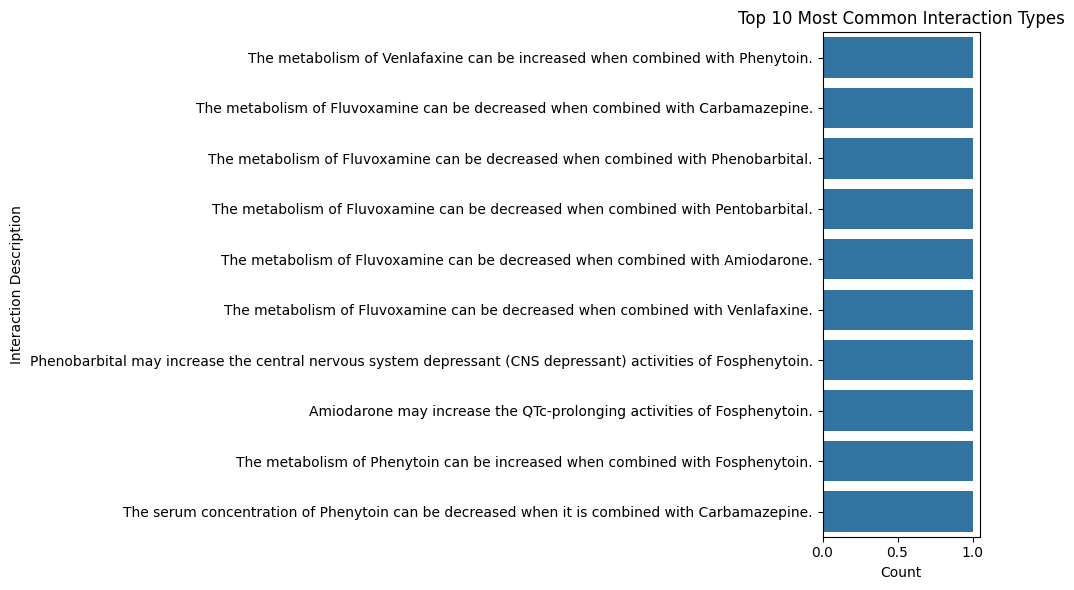

In [8]:
interaction_types = filtered_df['Interaction Description'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=interaction_types.values, y=interaction_types.index)
plt.title('Top 10 Most Common Interaction Types')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

### EDA Findings:
The dataset contains drug pairs with their interaction descriptions.

Digoxin appears to be the most common drug in interactions.

The most common interaction type is "may decrease the cardiotoxic activities".

The interaction network shows how the top drugs are interconnected.

### Neural Network for Drug-Drug Interaction Analysis


In [9]:
# Preprocess the data
# Create a binary classification task (severe vs non-severe interactions)
df['Severe'] = df['Interaction Description'].apply(lambda x: 1 if ('increase' in x and ('risk' in x or 'severity' in x)) else 0)

In [10]:
# Encode drugs
drug_encoder = LabelEncoder()
all_drugs = pd.concat([df['Drug 1'], df['Drug 2']]).unique()
drug_encoder.fit(all_drugs)

df['Drug 1_encoded'] = drug_encoder.transform(df['Drug 1'])
df['Drug 2_encoded'] = drug_encoder.transform(df['Drug 2'])

In [11]:
# Split data
X = df[['Drug 1_encoded', 'Drug 2_encoded']].values
y = df['Severe'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [13]:
# Define the neural network
class DrugInteractionNN(nn.Module):
    def __init__(self, num_drugs, embedding_dim=64, hidden_dim=128):
        super(DrugInteractionNN, self).__init__()
        self.drug_embedding = nn.Embedding(num_drugs, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        drug1 = x[:, 0]
        drug2 = x[:, 1]
        
        drug1_embed = self.drug_embedding(drug1)
        drug2_embed = self.drug_embedding(drug2)
        
        combined = torch.cat([drug1_embed, drug2_embed], dim=1)
        x = torch.relu(self.fc1(combined))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return self.sigmoid(x)

In [14]:
# Initialize model
num_drugs = len(drug_encoder.classes_)
model = DrugInteractionNN(num_drugs)
print(model)

DrugInteractionNN(
  (drug_embedding): Embedding(1701, 64)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)


### Model Visualization


In [20]:


writer = SummaryWriter()
writer.add_graph(model, torch.zeros([1, 2]).long())
writer.close()

### Training the Model


In [21]:
# Training setup
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20
batch_size = 64

# Training loop
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / (len(X_train) / batch_size))
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test).squeeze()
        val_loss = criterion(val_outputs, y_test)
        val_losses.append(val_loss.item())
    
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

Epoch 1/20, Train Loss: 0.3451, Val Loss: 0.2259
Epoch 2/20, Train Loss: 0.2088, Val Loss: 0.1939
Epoch 3/20, Train Loss: 0.1790, Val Loss: 0.1760
Epoch 4/20, Train Loss: 0.1623, Val Loss: 0.1646
Epoch 5/20, Train Loss: 0.1465, Val Loss: 0.1549
Epoch 6/20, Train Loss: 0.1352, Val Loss: 0.1467
Epoch 7/20, Train Loss: 0.1240, Val Loss: 0.1388
Epoch 8/20, Train Loss: 0.1147, Val Loss: 0.1310
Epoch 9/20, Train Loss: 0.1061, Val Loss: 0.1240
Epoch 10/20, Train Loss: 0.0981, Val Loss: 0.1188
Epoch 11/20, Train Loss: 0.0920, Val Loss: 0.1145
Epoch 12/20, Train Loss: 0.0858, Val Loss: 0.1150
Epoch 13/20, Train Loss: 0.0802, Val Loss: 0.1120
Epoch 14/20, Train Loss: 0.0765, Val Loss: 0.1105
Epoch 15/20, Train Loss: 0.0725, Val Loss: 0.1107
Epoch 16/20, Train Loss: 0.0689, Val Loss: 0.1053
Epoch 17/20, Train Loss: 0.0656, Val Loss: 0.1052
Epoch 18/20, Train Loss: 0.0620, Val Loss: 0.1058
Epoch 19/20, Train Loss: 0.0601, Val Loss: 0.1035
Epoch 20/20, Train Loss: 0.0558, Val Loss: 0.1064


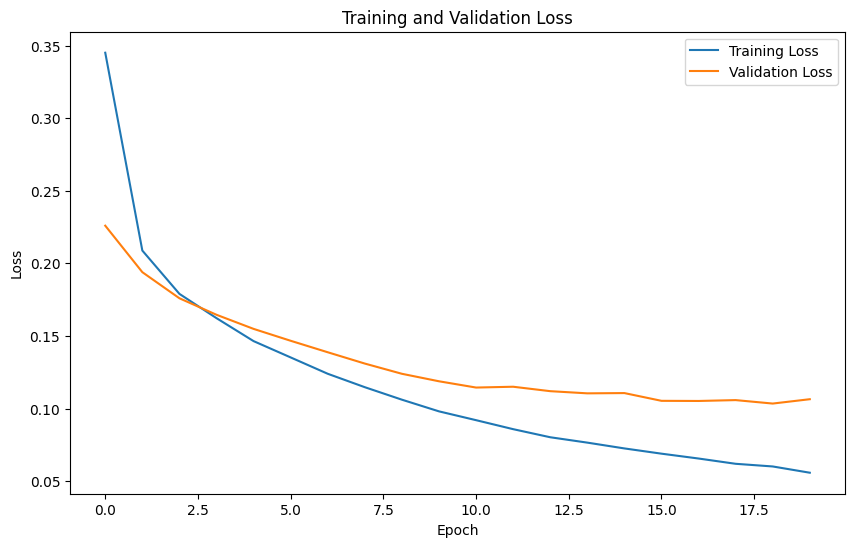

In [22]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Save the model
torch.save(model.state_dict(), 'model/drug_interaction_model.pth')

### Model Evaluation


              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     26107
         1.0       0.95      0.95      0.95     12202

    accuracy                           0.97     38309
   macro avg       0.96      0.96      0.96     38309
weighted avg       0.97      0.97      0.97     38309



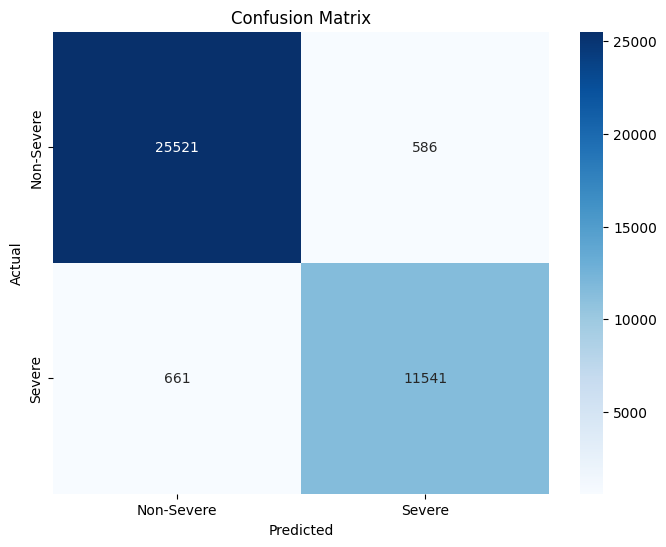

In [25]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze()
    y_pred_class = (y_pred > 0.5).float()

# Classification report
print(classification_report(y_test.numpy(), y_pred_class.numpy()))

# Confusion matrix
cm = confusion_matrix(y_test.numpy(), y_pred_class.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Severe', 'Severe'], 
            yticklabels=['Non-Severe', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

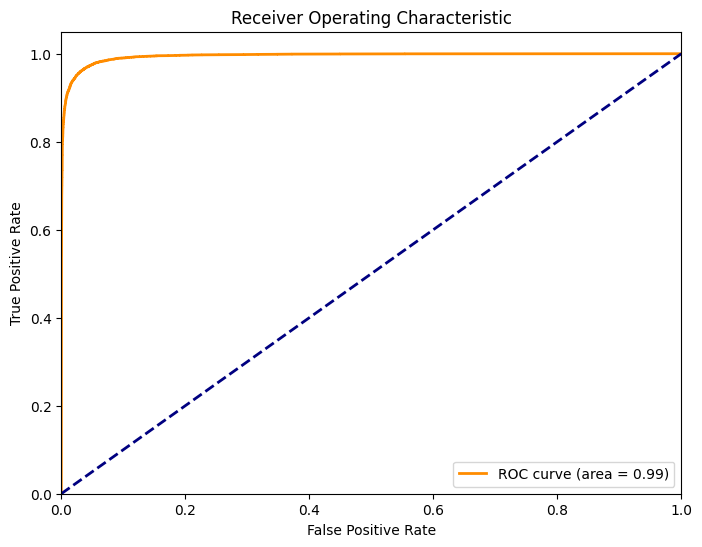

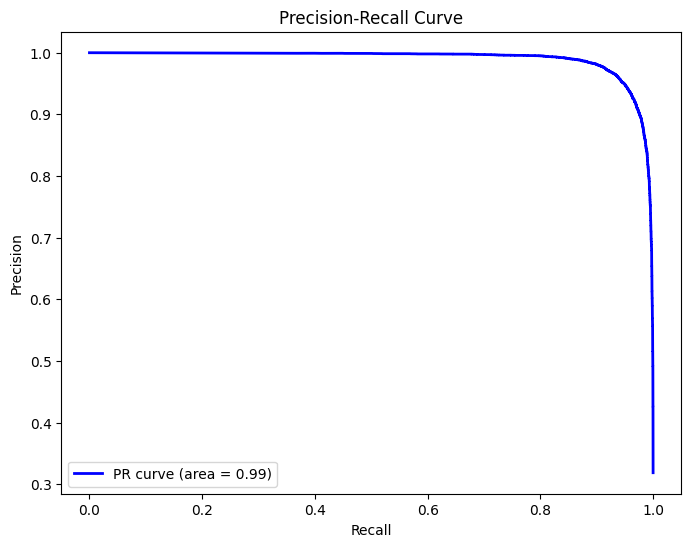

In [26]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test.numpy(), y_pred.numpy())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test.numpy(), y_pred.numpy())
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### Model Validation Examples


In [27]:
# Example predictions
def predict_interaction(drug1, drug2):
    try:
        drug1_enc = drug_encoder.transform([drug1])[0]
        drug2_enc = drug_encoder.transform([drug2])[0]
    except:
        return "One or both drugs not found in dataset"
    
    with torch.no_grad():
        input_tensor = torch.tensor([[drug1_enc, drug2_enc]], dtype=torch.long)
        prediction = model(input_tensor).item()
    
    severity = "Severe" if prediction > 0.5 else "Non-Severe"
    return f"Interaction between {drug1} and {drug2} is predicted to be {severity} (probability: {prediction:.3f})"

# Example 1: Known severe interaction
print(predict_interaction('Digoxin', 'Amphotericin B'))

# Example 2: Known non-severe interaction
print(predict_interaction('Digoxin', 'Aminolevulinic acid'))

# Example 3: New combination
print(predict_interaction('Verteporfin', 'Paclitaxel'))

Interaction between Digoxin and Amphotericin B is predicted to be Non-Severe (probability: 0.000)
Interaction between Digoxin and Aminolevulinic acid is predicted to be Non-Severe (probability: 0.000)
Interaction between Verteporfin and Paclitaxel is predicted to be Severe (probability: 0.933)


### Streamlit app to showcase your drug interaction model with a clean UI

Start Streamlit app using the below command:

    streamlit run app.py

Once started, use the localhost URL to validate. This can also be deployed in a Docker container:

    http://localhost:8501/